<a href="https://colab.research.google.com/github/zdhiman/100days-ml/blob/master/2022/bandit_pricing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bandit Pricing
Source: 
* Improving Multi-Armed Bandit Algorithms for Pricing ([link](https://trovo.faculty.polimi.it/01papers/trovo2018improving_b.pdf))
* Non stationary bandit for experiments with reinforcement learning ([link](https://github.com/dquail/NonStationaryBandit))

In [1]:
import numpy as np
from random import randrange 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import collections

# K is the number of arms
def demand_curve(K):
    # arms value from 1 to 20
    x = np.linspace(1,20, K)
    # mean and standard deviation
    mu = randrange(4)+6
    print('mu',mu)
    sigma = 1.6  
    s = np.random.normal(mu, sigma, 100)
    s = [round(i,1) for i in s]
    # calculate return from arm
    return x,s

# x is list of arms,s is the probability
def demand1(x,s):
    mi = 1 # conversion rate
    reward = mi*sum([1 for i in s if x<= i])/100
    #add some noise
    if reward <= 0.9:
        reward = reward + 1*randrange(10)/100
    return reward


# p0 is the number of fails from each arm
# p1 is the number of successes from each arm
# t is the time
def bandits(x,p0,p1,t):
    arms = x
    n_arms = len(arms)
    # conversion rate
    mi = 0.3
    n = [sum(x) for x in zip(p0, p1)]
    upper = {}
    upper_lst = []
    for kk in range(n_arms-1,-1,-1):
        #Search of optimal value for j, from kk to 1
        ord_n = [n[i] for i in range(kk,-1,-1)]
        ord_p1 = [p1[i] for i in range(kk,-1,-1)]
        temp_upper = np.cumsum(ord_p1)
        temp_upper1 = np.cumsum(ord_n)
        temp_upper2 =  (4 * np.log(t-1) + np.log(kk+1)) #/ 2
        temp_upper3 = np.cumsum(ord_n)
        temp_upper1 = [i / j for i, j in zip(temp_upper, temp_upper1)]
        temp_upper2 = np.sqrt(2*mi*temp_upper2/temp_upper3)
        temp_upper = [i + j for i, j in zip(temp_upper1, temp_upper2)]
        upper[kk] = min([min(temp_upper), 1])
        
    #Value computation
    v = [_ for i,_ in upper.items()]
    v.reverse()
    upper_lst = v
    upp = [upper_lst[i]*i for i in range(1,len(upper_lst))]
    max_val =  max(upp)
    idx_best_arm = upp.index(max_val)
    return idx_best_arm,upper_lst


# N is the min and max time,K is the number of arms,x is the return from demand_curve(K),s is the probability
def run_arms(N,K,x,s):    
    # circular buffer to wait for convergence
    len_ = 10
    d = collections.deque(maxlen=len_)
    # number of successes from each arm
    p1 = [0 for i in range(0,K)]
    # number of fails from each arm
    p0 = [0 for i in range(0,K)]
    arm_chs = []
    mean_arm = 0
    mean_arm_rt = 0
    exit_search = 0
    arms_reward = []
    # loop in time
    for time in range(N[0],N[1]):
        # training arms
        if exit_search == 0:
            #loop through arms
            for arm in range(0,K):
                # sum successes and fails from each arm
                if demand1(arm,s) >= 0.8:
                    p1[arm] = p1[arm] + 1
                    arms_reward.append(demand1(arm,s)*arm)
                else:
                    p0[arm] = p0[arm] + 1
                    arms_reward.append(demand1(arm,s)*arm)

            # save chosen arm
            arm_chs_,upper_lst = bandits(x,p0,p1,time)
            #print('chosen arm',arm_chs_)
            arm_chs.append(arm_chs_)
            d.append(arm_chs[-1])
            # wait for convergence
            if len(d)==len_:
                exit_search = 1
            mean_arm = (int(np.mean(d)))
        # choose best arm
        else:
            arms_reward.append(demand1(arm_chs_,s)*arm_chs_)
    print('chosen arm:',arm_chs_)        
    return arms_reward,upper_lst

mu 9
chosen arm: 6
mu 9
chosen arm: 8
mu 6
chosen arm: 5


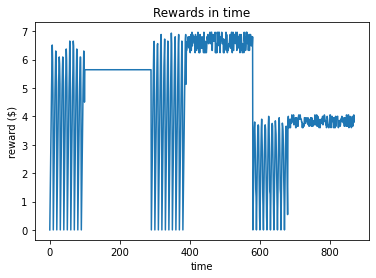

In [2]:
import matplotlib.pyplot as plt
# number of demand curve changes
d_chg = 3
x_,y_ = [],[]
for j in range(0,d_chg):
    K = 10
    x,s = demand_curve(K)
    N = [200*j,200*(j+1)]
    arms_reward,upper_lst = run_arms(N,K,x,s)
    [y_.append(arms_reward[i]) for i in range(0,len(arms_reward))]
    N1 = len(arms_reward)
    [x_.append(i) for i in range(N1*j,N1*(j+1))]
    
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('time');
ax.set_ylabel('reward ($)');
ax.set_title('Rewards in time')
plt.plot(x_,y_);

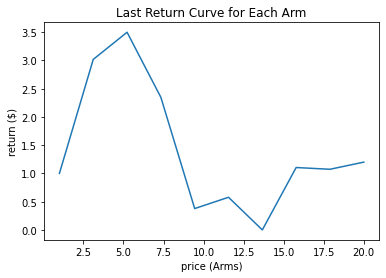

In [3]:
fig, ax = plt.subplots(1, 1)
y = [demand1(i,s) for i in x]
plt.plot(x,y*x)
ax.set_xlabel('price (Arms)');
ax.set_ylabel('return ($)');
ax.set_title('Last Return Curve for Each Arm');